##MULTI TASK DEEP LEARNING NEURAL NETWORK

This contains a lot of the code from the other multitask file, but just what is required to run the multitask neural net with random splits multiple times.



In [2]:

%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import torch
from bayes_opt import BayesianOptimization
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from math import sqrt
import random
import itertools

#Load some of the data
exp_data = pd.read_csv('../exp.tab', sep='\t', index_col=0)
cnv_data = pd.read_csv('../cnv.tab', sep='\t', index_col=0)
ydat = pd.read_csv('../labels.tab', sep='\t', index_col=0)
train_activity_data = pd.read_csv('../train_activity.tab', sep='\t')
test_activity_data = pd.read_csv('../test_activity.tab', sep ='\t')

#best ~1000 tasks
top_tasks = pd.read_csv("../combined_stats.tab", sep='\t')
tasks = top_tasks.iloc[:,0].values
ydat_best = ydat.transpose()[tasks]
ydat_best = ydat_best.transpose()

#concatenate two data frames
frames = [exp_data, cnv_data]

xdatw = pd.concat(frames)

In [2]:
#Deep Learning Net Class

class EssentialityNet:

    def __init__(self):
        self.inputnum = xdatw.shape[0]
        self.trainscores = []
        self.testscoreslist = []
        self.learning_rate = 0.00009
        self.H = 100
        self.n_iter = 300 #training iterations
        self.minimum = 100000
        self.stopcounter = 3
        self.layernum = 1
        self.layers = []
                
        #model
        self.model = torch.nn.Sequential(
        torch.nn.Linear(self.inputnum, self.H),
        torch.nn.ReLU(),
        torch.nn.Linear(self.H, 1138),
        )
        
        #set loss function and optimizer
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    #plot scores
    def plot(self, trainscores, testscores):
        x = np.arange(self.n_iter)
        plt.plot(x, self.trainscores, label='Train')
        plt.title('Training vs Test Accuracy')
        plt.xlabel('NN Training Iterations')
        plt.ylabel('Accuracy')
    
        plt.plot(np.asarray(x), np.asarray(testscores), label='Test') #plot
        plt.legend()
        
    #sets the proper method
    def setModel(self, Layernum, Neuronnum):  
        
        self.layernum = int(round(Layernum))
        self.H = int(round(Neuronnum))
        
        #initial input layer
        self.layers.append(torch.nn.Linear(self.inputnum, self.H))
        
        for n in range(self.layernum):
            if n != 0:
                self.layers.append(torch.nn.Linear(self.H, self.H))
            self.layers.append(torch.nn.ReLU())
            
        self.layers.append(torch.nn.Linear(self.H, 1138))
        
        #set the method to whatever layers were chosen
        self.model = torch.nn.Sequential(*self.layers)
    
    def setRegularization(self, L2Reg):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay= L2Reg)

    def fit(self, xtrain, ytrain, xtest, ytest):
      
        #convert to variables
        xtrain_var = Variable(torch.FloatTensor(xtrain))
        xtest_var = Variable(torch.FloatTensor(xtest))
        ytrain_var = Variable(torch.FloatTensor(ytrain))
        ytest_var = Variable(torch.FloatTensor(ytest))
        
        for t in range(self.n_iter):
        
            #calculate loss
            ypred = self.model(xtrain_var)

            diff = self.loss(ypred, ytrain_var)
            self.trainscores.append(diff.data[0])
            
            #test performance
            ypredtest = self.model(xtest_var)
            difftest = self.loss(ypredtest, ytest_var)
            
            #find the best point
            if t > 10 and self.minimum < difftest.data[0]:
                self.stopcounter -= 1

                if self.stopcounter == 0:
                    self.n_iter = t
                    self.trainscores.pop()
                    break
            elif t > 10 and self.stopcounter < 3:
                self.stopcounter += 1
            
            self.minimum = difftest.data[0]
            
            self.testscoreslist.append(difftest.data[0])
            
            #zero gradients
            self.optimizer.zero_grad()
            #backpropagate
            diff.backward() 
            #update weights
            self.optimizer.step() 

    # predict with the test data
    def predict(self, X):
        
        X_var = Variable(torch.FloatTensor(X))
        return self.model(X_var) 
    
#other functions for running the nn

def figureoutnetwork(layernum, neuronnum, l2reg):
    n = EssentialityNet()
    n.setModel(layernum, neuronnum)
    n.setRegularization(l2reg)
            
    n.fit(xtrain_val, ytrain_val, xtest_val, ytest_val)
    predictions = n.predict(xtest)
#     return(calculateRMSE(predictions, ytest))
    saveRMSE(predictions, ytest)

def figureoutnetwork3(neuronnum, l2reg):
    n = EssentialityNet()
    n.setModel(3, neuronnum)
    n.setRegularization(l2reg)
            
    n.fit(xtrain_val, ytrain_val, xtest_val, ytest_val)
    predictions = n.predict(xtest)
    return(calculateRMSE(predictions, ytest))
    
#calculate RMSE function
def calculateRMSE(predicts, actuals):
    mses = []  
    multitaskrmses = []
    preds = predicts.data.numpy()

    for i in range(preds.shape[1]):
        mses.append(((preds[:,i] - actuals[:,i])**2).mean())
        multitaskrmses.append(sqrt(mses[i]))

    print(len(multitaskrmses))       
    return(np.mean(multitaskrmses))

def saveRMSE(predicts, actuals):
    mses = []  
    multitaskrmses = []
    preds = predicts.data.numpy()

    for i in range(preds.shape[1]):
        mses.append(((preds[:,i] - actuals[:,i])**2).mean())
        multitaskrmses.append(sqrt(mses[i]))
    
    #open a file for saving rmses
    rmses_file = open('rmses_' + str(fileno) + ".tab", 'w')
    
    for item in multitaskrmses:
          rmses_file.write("%s\n" % item)

In [5]:
for fileno in range(10):

    #starting runs with random splits:
    traininglabels = random.sample(range(0, 206), 142)
    traininglabels.sort()
    testinglabels = random.sample([x for x in range(206) if x not in traininglabels], 64)

    #index the data with the proper labels
    xtrain_not_norm = xdatw.iloc[:,traininglabels].transpose()
    xtest_not_norm = xdatw.iloc[:,testinglabels].transpose()
    ytrain = ydat_best.iloc[:,traininglabels].transpose().values
    ytest = ydat_best.iloc[:,testinglabels].transpose().values

    #normalize inputs
    xtrain = preprocessing.scale(xtrain_not_norm)
    xtest = preprocessing.scale(xtest_not_norm)

    #create validation set
    xtrain_val, xtest_val, ytrain_val, ytest_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=434)

    #do not uncomment this if you do not want to retrain
###     figureoutnetwork(3, 356, 0.012)



In [22]:
#open and concatenate the files
myrmses0 = pd.read_csv('rmses_0.tab', header=None)
myrmses1 = pd.read_csv('rmses_1.tab', header=None)
myrmses2 = pd.read_csv('rmses_2.tab', header=None)
myrmses3 = pd.read_csv('rmses_3.tab', header=None)
myrmses4 = pd.read_csv('rmses_4.tab', header=None)
myrmses5 = pd.read_csv('rmses_5.tab', header=None)
myrmses6 = pd.read_csv('rmses_6.tab', header=None)
myrmses7 = pd.read_csv('rmses_7.tab', header=None)
myrmses8 = pd.read_csv('rmses_8.tab', header=None)
myrmses9 = pd.read_csv('rmses_9.tab', header=None)

rmses_total = pd.concat((myrmses0, myrmses1, myrmses2, myrmses3, myrmses4, myrmses5, myrmses6, myrmses7, myrmses8, myrmses9), axis = 1, )


In [49]:
#get means across trials
rmse_means = pd.DataFrame.mean(rmses_total, axis=1)
dnnlist = (list(rmse_means.values))
print(np.mean(dnnlist))
#save to file
mean_rmses_file = open('mean_rmses.tab', 'w')

# for item in list(rmse_means.values):
#     mean_rmses_file.write("%s\n" % item)

1.01065570239


In [46]:
#compare
top_tasks['dnn.rmse'] = dnnlist

top_tasks = top_tasks[['jklm.rmse', 'ranger.rmse', 'mkl.d9.rmse', 'rf.d9.rmse', 'glmm.dense.rmse', 'glmm.sparse.rmse', 'dnn.rmse']]
top_tasks

,jklm.rmse,ranger.rmse,mkl.d9.rmse,rf.d9.rmse,glmm.dense.rmse,glmm.sparse.rmse,dnn.rmse
0,0.952833,0.960496,0.948655,0.961768,0.962843,0.962658,0.882877
1,1.060365,1.074067,1.058601,1.067794,1.032906,1.124052,1.007232
2,0.946342,0.931658,0.975606,0.941134,0.934963,0.973344,0.881774
3,1.074409,1.053793,1.068510,1.056220,1.171792,1.019199,1.017913
4,1.298735,1.284004,1.276571,1.346348,1.254156,1.316945,1.292043
5,1.019320,1.018533,1.026431,1.039957,1.031455,1.032844,0.968281
6,0.903709,0.906174,0.892708,0.901269,0.897027,0.939720,0.954082
7,0.987778,0.990707,1.014963,1.050599,1.015290,1.056278,0.916968
8,0.962102,0.944543,0.925711,0.934242,0.961486,0.963235,0.937306
9,1.025180,1.034207,1.028851,1.061582,1.021382,0.997408,0.945645


In [47]:
#comparing with other methods for each task
best_rmse = {'dnn.rmse':0,'glmm.dense.rmse':0, 'mkl.d9.rmse':0, 'rf.d9.rmse':0,'jklm.rmse':0, 'glmm.sparse.rmse':0, 'ranger.rmse':0}

for i in range(1138):
    best_rmse[np.argmin(top_tasks.iloc[i])] += 1

best_rmse

{'dnn.rmse': 393,
 'glmm.dense.rmse': 115,
 'glmm.sparse.rmse': 113,
 'jklm.rmse': 213,
 'mkl.d9.rmse': 112,
 'ranger.rmse': 163,
 'rf.d9.rmse': 29}

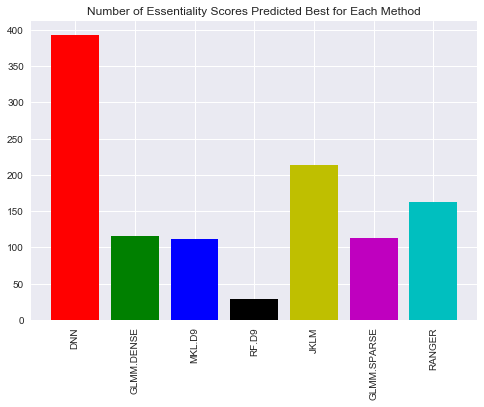

In [48]:
#plotting who did best per task
colors = 'rgbkymc'
keys = []

keys = [s.replace(".rmse", "").upper() for s in list(best_rmse.keys())]

plt.bar(range(len(best_rmse)), best_rmse.values(), align='center', color=colors)
plt.xticks(range(len(best_rmse)), keys, rotation='vertical')
plt.title('Number of Essentiality Scores Predicted Best for Each Method')

plt.show()